In [46]:
%matplotlib inline
from datetime import datetime, date, time
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
import plotly as pl

train=pd.read_csv('TrainSample.csv',sep=';' )
test=pd.read_csv('TestSample.csv',sep=';' )

In [69]:
ind=range(6,45)
ind.insert(0,1)
ind.insert(1,2)
names=[train.columns[i] for i in ind]


the above is just to collect the indexes of variables that are not:

API, any date, target

## Comparison of Variances

In [73]:
train_vars=[[name,np.var(train[name])] for name in names]# test does not have oil and gas
pd.DataFrame(train_vars).sort_values(1).head()


,0,1
13,Res_PPLS (Ohmm),0.486012
29,Max_Treating_pressure (KPa),0.560473
38,Shot_Total,0.633596
22,Zone,0.882459
3,Depth_TVD_PPLS (ft),0.896236


In [74]:
pd.DataFrame(train_vars).sort_values(1).tail()

,0,1
21,Heat_Flow (W/m2),1.161726
30,Min_Treating_Pressure (KPa),1.170414
18,Temp_Anomaly (F),1.187651
14,GR_PPLS (API),1.371725
24,Frac_Gradient (PSI/ft),1.651402


The varicane of the **training** set varibales is between 0.48 and 1.65

The varicane of the **testing**  set varibales is between 0.05 and 1.31   (not shown)

We want to compare the variances between training and testing now.
For that, we do for each variable:

|train var - test var| / total variance

In [75]:
test_vars=[[name,np.var(test[name])] for name in names]# test does not have oil and gas


vars_difference=[ [test_vars[i][0], np.abs(test_vars[i][1]- train_vars[i][1])*890/(test_vars[i][1]*235+ train_vars[i][1]*460)] for i in range(len(train_vars))]
vars_difference=pd.DataFrame(vars_difference)
vars_difference=vars_difference.sort_values(1,ascending=False)
vars_difference.columns=('Variable','Normalized Difference of Variance Train and Test')
vars_difference.head(9)

,Variable,Normalized Difference of Variance Train and Test
24,Frac_Gradient (PSI/ft),1.837926
13,Res_PPLS (Ohmm),1.265093
29,Max_Treating_pressure (KPa),1.189994
14,GR_PPLS (API),0.885649
30,Min_Treating_Pressure (KPa),0.482463
10,PR_PPLS,0.431738
33,Min_Rate_Slurry (bpm),0.414365
18,Temp_Anomaly (F),0.411965
36,ISIP (KPa),0.380886


So we actually have a significant differene in the variance between train and test in some variables. That's also a difficulty for anova..

## Comparision of the means ( unifished)
We calculate the mean for each varible and compare train set with test set, normalized by the standard de

In [77]:
train_means=[[name,np.mean(train[name])] for name in names]# test does not have oil and gas


test_means=[[name,np.mean(test[name])] for name in names]# test does not have oil and gas
test_means.insert(0,['Surf_X',np.mean(test['Surf_X'])])
test_means.insert(1,['Surf_Y',np.mean(test['Surf_Y'])])

means_difference=[ [test_means[i][0], np.abs(test_means[i][1]- train_means[i][1])] for i in range(len(train_means))]
means_difference=pd.DataFrame(means_difference)

The highest difference in means have the two variables Shut_inPressure_Fil and min Rate Slurry, so we are gonna plot them.

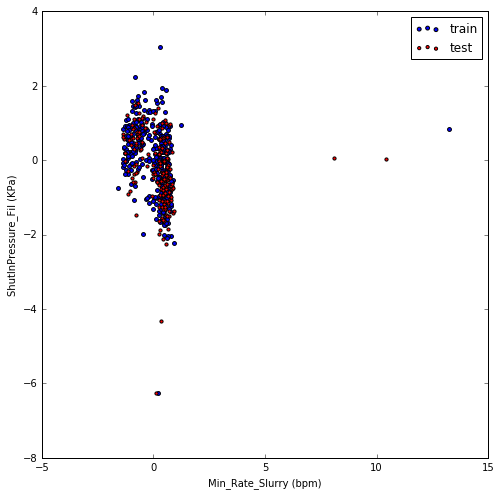

In [5]:
n=37
plt.figure(figsize=(8,8))

plt.scatter(train[train.columns[n]],train[train.columns[n+1]],c='blue',label='train',s=15)
plt.scatter(test[test.columns[n]],test[test.columns[n+1]],c='red',label='test',s=10)
plt.xlabel(train.columns[n])
plt.ylabel(train.columns[n+1])
plt.legend()

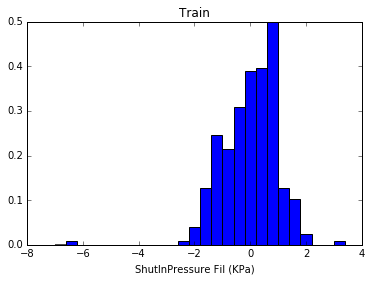

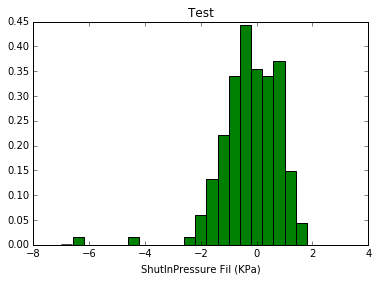

In [12]:
bins2=np.arange(-7,4,0.4)
plt.hist(train.dropna()[train.columns[n+1]],bins=bins2,normed=True)
plt.xlabel('ShutInPressure Fil (KPa)')
plt.title('Train')
plt.figure()

plt.hist(test.dropna()[test.columns[n+1]],bins=bins2,normed=True,color='g')
plt.xlabel('ShutInPressure Fil (KPa)')
plt.title('Test')

At least visually we cannot see a significant difference. ( we will do a ks test of euquality of distributins later) As the varicance not too different for 
'ShutInPressure_Fil' we can do an anova test.

## KS Test for Equality of distributions

In [121]:
ksTests=[(sp.stats.ks_2samp(train[name],test[name]).pvalue,name) for name in names]
ksTests=pd.DataFrame(ksTests)
ksTests.columns=('p-value','variable')
ksTests=ksTests.sort_values('p-value')
ksTests[:10]                                                                  

,p-value,variable
37,0.001678,Shot_Density (shots/ft)
26,0.032129,Proppant_in_Formation (kg)
34,0.044326,ShutInPressure_Fil (KPa)
2,0.054308,Lateral_Length (ft)
14,0.059435,GR_PPLS (API)
25,0.060360,Proppant_Designed (kg)
23,0.073545,Nbr_Stages
33,0.107922,Min_Rate_Slurry (bpm)
31,0.110066,Avg_Rate_Slurry (bpm)
38,0.118013,Shot_Total


With risk of alpha = 0.05 we have to throw the null hypothesis of equality of distributions for 3 festures

 ## Test for normality
 If we have normality in certain features, the test of equals means in train and test in each variable could be more accurate... so we check each variable in train and test for normality..

In [120]:

norm_test_train=[sp.stats.kstest((train.dropna()[name]-np.mean(train.dropna()[name]))/np.sqrt(np.var(train.dropna()[name])),'norm') for name in names]

norm_test_train=pd.DataFrame(norm_test_train)
norm_test_train.sort_values('pvalue').tail(15)

,statistic,pvalue
8,0.097887,0.004438
29,0.096876,0.005030
17,0.092110,0.008917
4,0.089715,0.011761
1,0.086876,0.016173
5,0.083079,0.024373
19,0.080973,0.030358
35,0.078583,0.038685
31,0.072257,0.070943
27,0.064149,0.143310


the majority of the feature can no be considered normally distributed. The tail above just shows the features with high p-value. ( those that are most likely to be normally distributed)